In [1]:
import torch
import numpy as np 
from gpytorch.kernels import ScaleKernel
from abc import ABC, abstractmethod
import gpytorch
from gpytorch.kernels import MaternKernel,RBFKernel
import os
import sys
from gpytorch.priors import GammaPrior

# Data path setup
notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '../code'))
if src_path not in sys.path:
    sys.path.append(src_path)
from util  import train, eval, plot_gpr_results, memory_dump, fetch_uci_dataset
import sys
from gps import IterativeGaussianProcess,CholeskyGaussianProcess
from plotting import plot_gp_simple,plot_gp_sample,plot_gp_simple_regions


%load_ext autoreload
%autoreload 2
device="cuda:0"
global_dtype=torch.float32
np.random.seed(42)
torch.manual_seed(42)

[KeOps] Warning : 
    The default C++ compiler could not be found on your system.
    You need to either define the CXX environment variable or a symlink to the g++ command.
    For example if g++-8 is the command you can do
      import os
      os.environ['CXX'] = 'g++-8'
    
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [2]:
def generate_data(true_function, train_range=(-3, 3), test_range=(-3, 3), 
                  n_train=100, n_test=100, noise_std=0.1, 
                  device='cuda:0', dtype=torch.float64):
    X_train = torch.linspace(train_range[0], train_range[1], n_train, dtype=dtype, device=device).unsqueeze(-1)
    y_train = true_function(X_train) + noise_std * torch.randn_like(X_train)
    
    X_test = torch.linspace(test_range[0], test_range[1], n_test, dtype=dtype, device=device).unsqueeze(-1)
    y_test = true_function(X_test)  # No noise added to test data
    
    return X_train, y_train.squeeze(), X_test, y_test.squeeze()

def true_function(x):
    return torch.sin(2 * x) + torch.cos(3 * x)
train_x, train_y, test_x, test_y = generate_data(true_function, test_range=(-5,5), dtype=global_dtype)

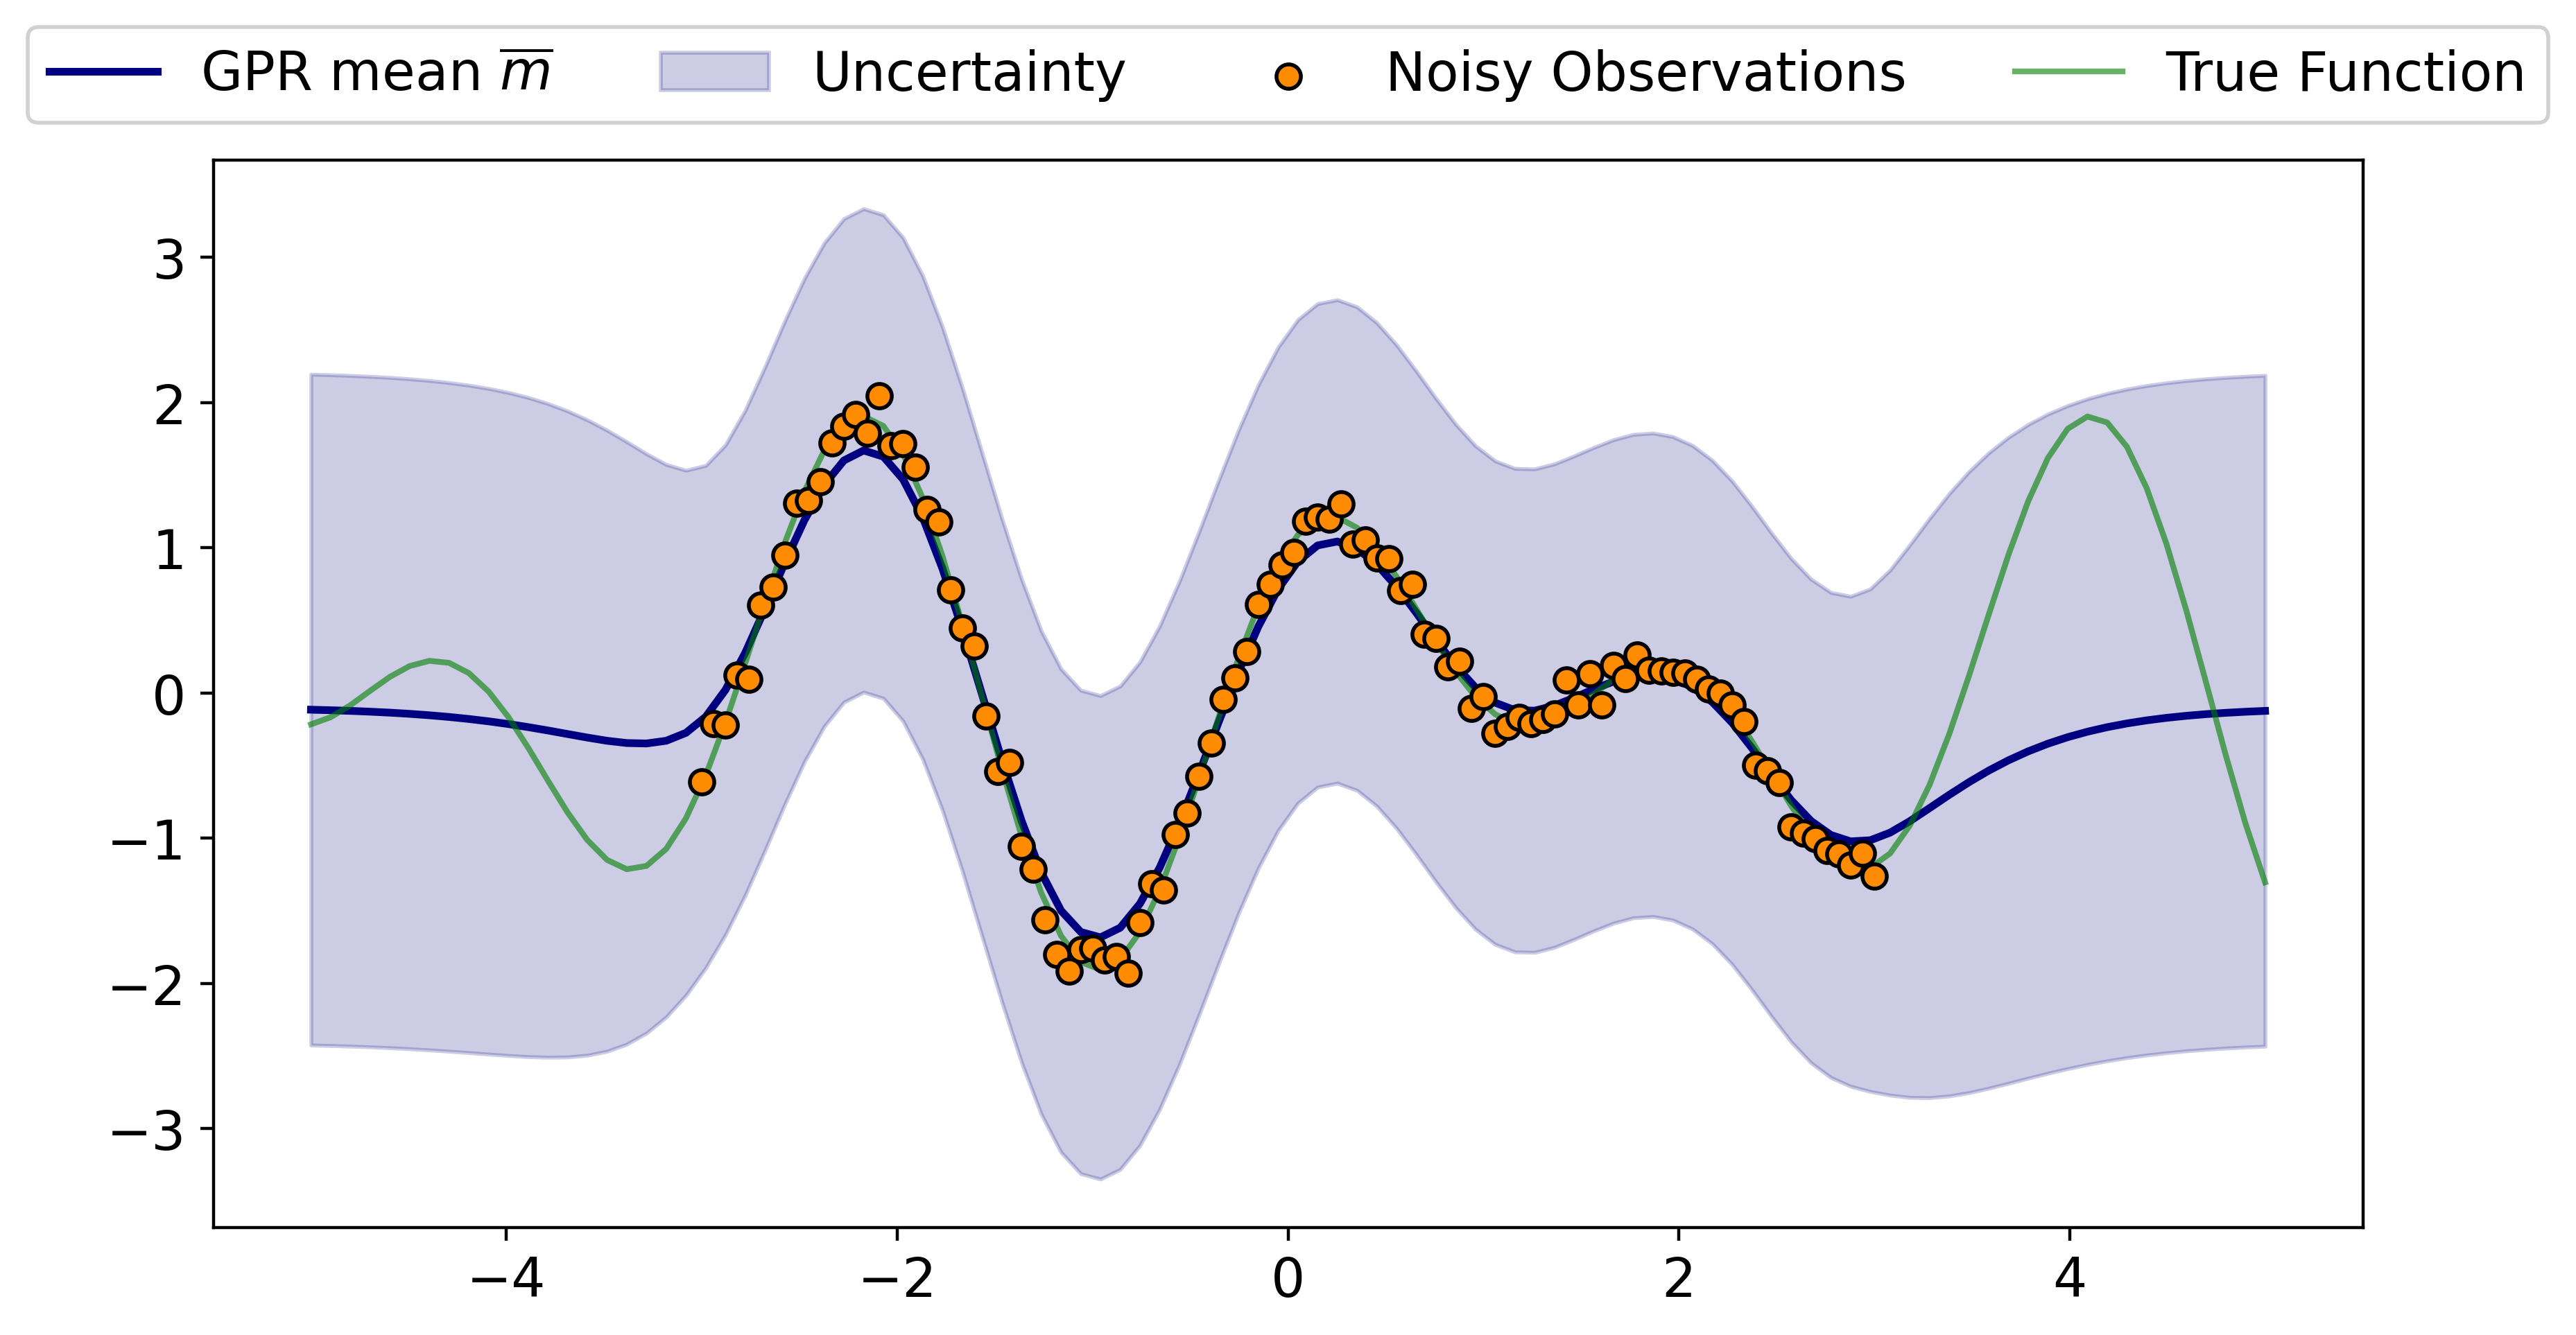

In [4]:
import torch
import gpytorch
import matplotlib.pyplot as plt

# Assume train_x, train_y, test_x, test_y are already defined.
# They can be generated with your generate_data function.

# Define the exact GP model using GPyTorch
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # The covariance uses a ScaleKernel wrapped around a Matérn kernel with nu=1.5
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5)
        )
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Move model and likelihood to the same device as the data
device = train_x.device
model = model.to(device)
likelihood = likelihood.to(device)

# Set into training mode
model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Use the marginal log likelihood (MLL) for training
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop
training_iterations = 1
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    # Optionally print loss to monitor training progress:
    # print(f'Iteration {i + 1}/{training_iterations} - Loss: {loss.item()}')

# Set the model in evaluation mode
model.eval()
likelihood.eval()

# Make predictions on the test set using fast predictive variance
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    mean = observed_pred.mean
    variance = observed_pred.variance
    std = torch.sqrt(variance)



plot_gp_simple(train_x.cpu(), train_y.cpu(), test_x.cpu(), mean.detach().cpu(), std.detach().cpu(), test_y.cpu())

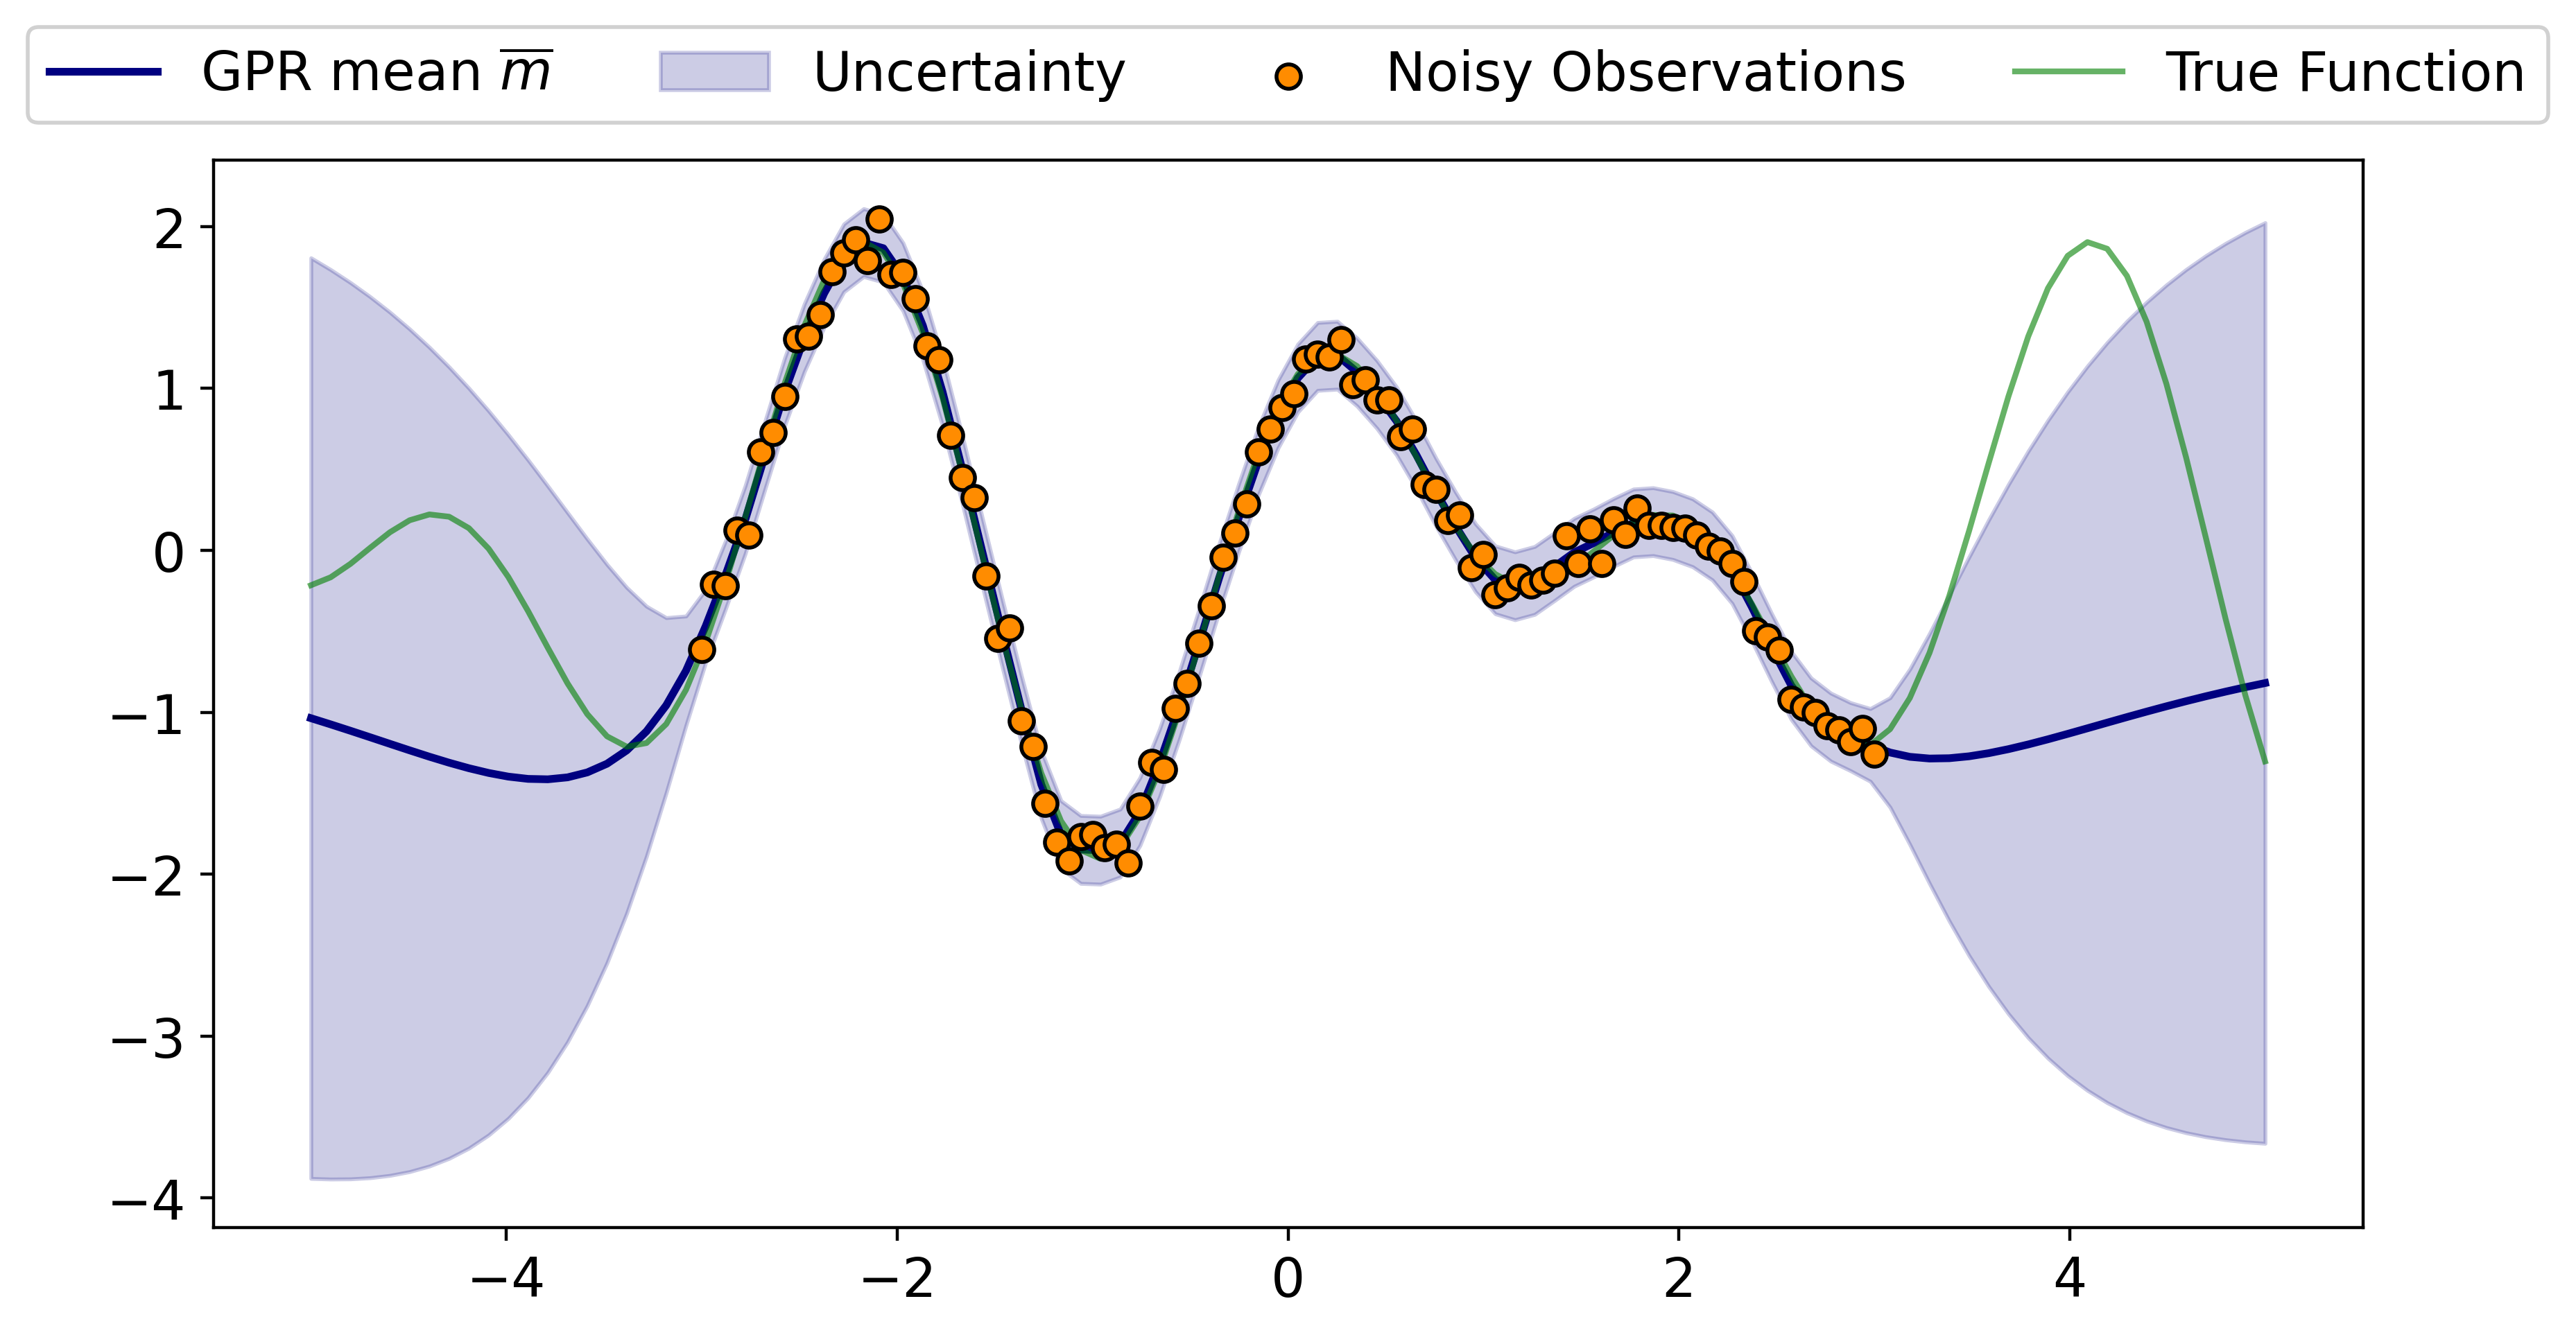

In [5]:
import torch
import gpytorch
import matplotlib.pyplot as plt

# Assume train_x, train_y, test_x, test_y are already defined.
# They can be generated with your generate_data function.

# Define the exact GP model using GPyTorch
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # The covariance uses a ScaleKernel wrapped around a Matérn kernel with nu=1.5
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5)
        )
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Move model and likelihood to the same device as the data
device = train_x.device
model = model.to(device)
likelihood = likelihood.to(device)

# Set into training mode
model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Use the marginal log likelihood (MLL) for training
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop
training_iterations = 50
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    # Optionally print loss to monitor training progress:
    # print(f'Iteration {i + 1}/{training_iterations} - Loss: {loss.item()}')

# Set the model in evaluation mode
model.eval()
likelihood.eval()

# Make predictions on the test set using fast predictive variance
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    mean = observed_pred.mean
    variance = observed_pred.variance
    std = torch.sqrt(variance)



plot_gp_simple(train_x.cpu(), train_y.cpu(), test_x.cpu(), mean.detach().cpu(), std.detach().cpu(), test_y.cpu())